This validates that the flat prior has the same effect as bounds.

In [1]:
import numpy as np
import betterplotlib as bpl

bpl.set_style()

In [3]:
def mean_of_normal(x_value, y_value, sigma, above):
    """
    Calculate the mean required for a normal distribution with a given width to take
    the given y value at a specific x value.

    :param x_value: Value at which the normal distribution takes a value of `y_value`.
    :param x_value: Value of the normal distribution at `x_value`
    :param above: Whether `x_value` should be a greater value than the returned mean
                  or not. This is needed since there are two roots, placing the normal
                  distribution lower or higher than the value paseed in.
    :return: The mean of normal distribution matching the properties above.
    """
    if y_value > 1:
        raise ValueError("Invalid y_value in `center_of_normal`")
    # This math can be worked out by hand
    # mean = x +- sqrt(ln(y^-2))
    second_term = sigma * np.sqrt(np.log(y_value ** (-2)))
    if above:
        second_term *= -1
    return x_value + second_term


def log_of_normal(x, mean, sigma):
    """
    Log of the normal distribution PDF. This is normalized to be 0 at the mean.

    :param x: X values to determine the value of the PDF at
    :param mean: Mean of the Gaussian
    :param sigma: Standard deviation of the Gaussian
    :return: natural log of the normal PDF at this location
    """
    return -0.5 * ((x - mean) / sigma) ** 2


def flat_with_normal_edges(x, lower_edge, upper_edge, side_width, boundary_value):
    """
    Probability density function that is flat with value at 1 in between two
    values, but with a lognormal PDF outside of that, with fixed width on both
    sides. This returns the log of that density.

    This is useful as it is continuous and smooth at the boundaries of the
    flat region.

    :param x: Value to determine the value of the PDF at.
    :param lower_edge: Lower value (see `mode`)
    :param upper_edge: Upper value (see `mode`)
    :param side_log_width: Gaussian width (in dex) of the normal distribution
                           used for the regions on either side.
    :param boundary_value: The value that the pdf should take at the edges. If this is
                           1.0, the flat region will extend to the edges. However, if
                           another is value is preferred at those edges, the flat
                           region will shrink to make room for that.
    :return:
    """
    lower_mean = mean_of_normal(lower_edge, boundary_value, side_width, False)
    upper_mean = mean_of_normal(upper_edge, boundary_value, side_width, True)

    if lower_edge > lower_edge:
        raise ValueError("There is not flat region with these parameters.")

    # check that we did the math right for the shape of the distribution
    assert np.isclose(
        np.exp(log_of_normal(lower_edge, lower_mean, side_width)), boundary_value
    )
    assert np.isclose(
        np.exp(log_of_normal(upper_edge, upper_mean, side_width)), boundary_value
    )

    if lower_mean <= x <= upper_mean:
        return 0
    elif x < lower_mean:
        return log_of_normal(x, lower_mean, side_width)
    else:
        return log_of_normal(x, upper_mean, side_width)

In [4]:
def a_prior(a):
    return flat_with_normal_edges(
        np.log10(a), np.log10(0.1), np.log10(15), 0.2, 0.5
    )
def q_prior(q):
    return flat_with_normal_edges(q, 0.3, 1.0, 0.1, 1.0)

In [5]:
a_values = np.logspace(-7, 3, 1000)
q_values = np.linspace(0, 1, 1000)

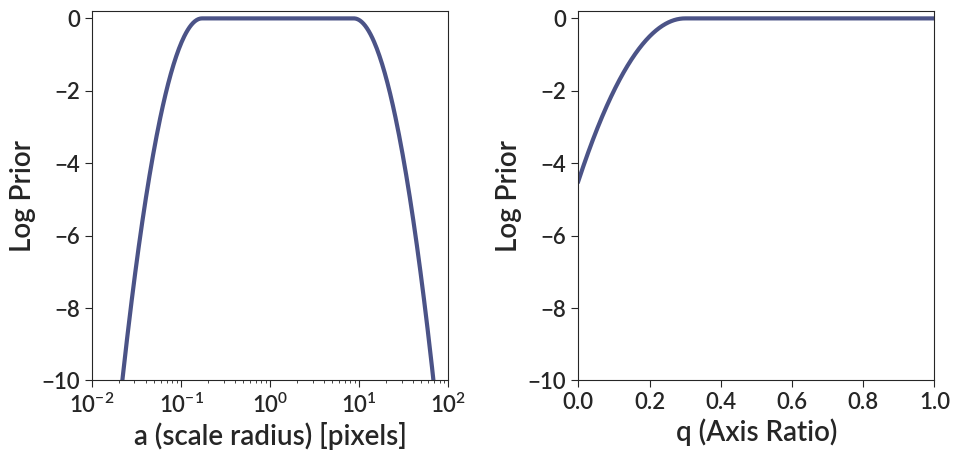

In [10]:
fig, axs = bpl.subplots(ncols=2, figsize=[10, 5])
axs[0].plot(a_values, [a_prior(a) for a in a_values])
axs[0].set_xscale("log")
# axs[0].set_yscale("log")
# axs[0].set_limits(0.01, 100, 1E-4, 2)
axs[0].set_limits(0.01, 100, -10, 0.2)
# axs[0].axvline(0.1, ls=":")
# axs[0].axvline(15, ls=":")
# axs[0].axhline(0.5, ls=":")
# axs[0].axhline(1, ls="--", c="0.7", zorder=0)
axs[0].add_labels("a (scale radius) [pixels]", "Log Prior")

axs[1].plot(q_values, [q_prior(q) for q in q_values])
# axs[1].set_yscale("log")
# axs[1].set_limits(0, 1, 1E-4, 2)
axs[1].set_limits(0, 1, -10, 0.2)
# axs[1].axvline(0.3, ls=":")
# axs[1].axhline(1, ls="--", c="0.7", zorder=0)
axs[1].add_labels("q (Axis Ratio)", "Log Prior")

fig.savefig("a_prior.png")